In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import cv2 as cv
import random as r
import numpy as np
import os
from google.colab.patches import cv2_imshow
#{'up':0,'down':1,'left':2,'right':3}
def env():
  global img,s_x,s_y
  global dista_ce,reward
  dista_ce=np.inf
  reward=0
  s_x,s_y=10,10
  img=np.zeros((500,500,3),dtype='uint8')
  img[0:500,0:10,0]=255
  img[0:10,0:500,0]=255
  img[490:500,0:500,0]=255
  img[0:500,490:500,0]=255
  x1=r.randrange(100,400,10)
  y1=r.randrange(x1,400,10)
  x2=r.randrange(100,400,10)
  y2=r.randrange(x2,400,10)
  x3=r.randrange(100,400,10)
  y3=r.randrange(x3,400,10)
  x4=r.randrange(100,400,10)
  y4=r.randrange(x4,400,10)
  x5=r.randrange(100,400,10)
  y5=r.randrange(x5,400,10)
  x6=r.randrange(100,400,10)
  y6=r.randrange(x6,400,10)
  img[x1:y1,x2:y2,0]=255
  img[x3:y3,x4:y4,0]=255
  img[x5:y5,x6:y6,0]=255
env()
def snake(s_x=10,s_y=10):
    img[s_x:s_x+10,s_y:s_y+10,1]=255
    return s_x,s_y
def food():
    global f_x,f_y
    f_x=r.randrange(10,490,10)
    f_y=r.randrange(10,490,10)        
    while img[f_x,f_y,2]!=img[f_x,f_y,0] or img[f_x,f_y,2]!=img[f_x,f_y,1]:
        f_x=r.randrange(10,490,10)
        f_y=r.randrange(10,490,10)
    img[f_x:f_x+10,f_y:f_y+10,2]=255
    return f_x,f_y
snake()
food()
def act(action):
    global s_x,s_y
    global dista_ce,reward
    s_x,s_y=snake(s_x,s_y)
    state=cv.resize(img.copy(),(100,100))
    #reward=0
    continu=False
    if(action==0):
        img[s_x:s_x+10,s_y:s_y+10,1]=0
        s_x=s_x-10
    elif(action==1):
        img[s_x:s_x+10,s_y:s_y+10,1]=0
        s_x=s_x+10
    elif(action==2):
        img[s_x:s_x+10,s_y:s_y+10,1]=0
        s_y=s_y-10
    elif(action==3):
        img[s_x:s_x+10,s_y:s_y+10,1]=0
        s_y=s_y+10
    snake(s_x,s_y)
    distance=np.sqrt(((s_x-f_x)**2)+((s_y-f_y)**2))
    if distance<dista_ce:
        dista_ce=distance
        reward=0.9
    elif distance>dista_ce:
        dista_ce=distance
        reward=-0.9
    next_state=cv.resize(img.copy(),(100,100))
    if img[s_x,s_y,1]==img[s_x,s_y,2]:
        img[f_x:f_x+10,f_y:f_y+10,2]=0
        reward=3
        dista_ce=np.inf
        food()
    if img[s_x,s_y,1]==img[s_x,s_y,0]:
        reward=-3
        continu=True
    return state,action,next_state,reward,continu 

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import os
import tensorflow as tf
import numpy as np

input_width = 100
input_height = 100
input_channels = 3
conv_n_maps = [32, 64, 64]
conv_kernel_sizes = [9, 5, 3]
conv_kernel_strides = [4, 2, 1]
conv_paddings = ['VALID'] * 3
conv_activation = [tf.nn.relu] * 3
n_hidden_in = 8 * 8 * 64
n_hidden = 512
hidden_activation = tf.nn.relu
n_outputs = 4
he_init = tf.contrib.layers.variance_scaling_initializer()
def q_network(X_state, name):
    prev_layer = X_state
    with tf.variable_scope(name,reuse=tf.AUTO_REUSE) as scope:
        for n_maps, kernel_size, strides, padding, activation in zip(
            conv_n_maps, conv_kernel_sizes, conv_kernel_strides, conv_paddings,
            conv_activation):
            prev_layer = tf.layers.conv2d(prev_layer, filters=n_maps,
                                          kernel_size=kernel_size,
                                          strides=strides, padding=padding,
                                          activation=activation,
                                          kernel_initializer=he_init)
        flattened = tf.reshape(prev_layer, [-1, n_hidden_in])
        hidden = tf.layers.dense(flattened, n_hidden,
                                 activation=hidden_activation,
                                 kernel_initializer=he_init)
        outputs = tf.layers.dense(hidden, n_outputs, kernel_initializer=he_init)
    trainable_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,
                                       scope=scope.name)
    trainable_vars_by_name = {var.name[len(scope.name):]: var
                              for var in trainable_vars}
    return outputs, trainable_vars_by_name
X_state = tf.placeholder(tf.float32, shape=(None, input_height, input_width,input_channels))
online_q_values, online_vars = q_network(X_state, 'q_networks/online')
target_q_values, target_vars = q_network(X_state, 'q_networks/target')
copy_ops = [var.assign(online_vars[name]) for name, var in target_vars.items()]
copy_online_to_target = tf.group(*copy_ops)
learning_rate = 1e-3
momentum = 0.95
with tf.variable_scope('training',reuse=tf.AUTO_REUSE) as scope:
    X_action = tf.placeholder(tf.int32, shape=(None,))
    y = tf.placeholder(tf.float32, shape=(None, 1))
    Q_target = tf.reduce_sum(online_q_values * tf.one_hot(X_action, n_outputs),axis=1, keepdims=True)
    error = tf.abs(y - Q_target)
    loss = tf.reduce_mean(tf.square(error))
    global_step = tf.Variable(0, trainable=False, name='global_step')
    optimizer = tf.train.MomentumOptimizer(learning_rate, momentum,use_nesterov=True)
    training_op = optimizer.minimize(loss, global_step=global_step)
init = tf.global_variables_initializer()
saver = tf.train.Saver()
class ReplayMemory(object):
    def __init__(self, maxlen):
        self.maxlen = maxlen
        self.buf = np.empty(shape=maxlen, dtype=np.object)
        self.index = 0
        self.length = 0

    def append(self, data):
        self.buf[self.index] = data
        self.index += 1
        self.index %= self.maxlen
        self.length = min(self.length + 1, self.maxlen)

    def sample(self, batch_size):
        return self.buf[np.random.randint(self.length, size=batch_size)]
replay_size = 100000
replay_memory = ReplayMemory(replay_size)
def sample_memories(batch_size):
    cols = [[], [], [], [], []]  # state, action, next_state, reward, continue
    for memory in replay_memory.sample(batch_size):
        for col, value in zip(cols, memory):
            col.append(value)
    cols = [np.array(col) for col in cols]
    return cols[0].reshape(-1,100,100,3), cols[1], cols[2].reshape(-1,100,100,3), cols[3].reshape(-1, 1),cols[4].reshape(-1, 1)
eps_min = 0.1
eps_max = 1.0
eps_decay_steps = 6000000
def epsilon_greedy(q_values, step):
    epsilon = max(eps_min,
                  eps_max - ((eps_max - eps_min) * (step / eps_decay_steps)))
    if np.random.random() < epsilon:
        return np.random.randint(n_outputs)
    return np.argmax(q_values)
def normalize(st,nst):
  return np.divide(st,255),np.divide(nst,255)
n_steps = 10000000
training_start = 10000
training_interval = 4
save_steps = 1000
copy_steps = 10000
discount_rate = 0.95
skip_start = 20
batch_size = 50
iteration = 0
done = True  # To reset the environment at the start.
loss_val = np.infty
game_length = 0
total_max_q = 0.0
mean_max_q = 0.0
checkpoint_path = "/content/drive/My Drive/A_snake/snake_dqn"

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Dense instead.


In [ ]:
# Main training loop

with tf.Session() as sess:
    if os.path.isfile(checkpoint_path + '.index'):
        saver.restore(sess, checkpoint_path)
    else:
        init.run()
        copy_online_to_target.run()
    while True:
        step = global_step.eval()
        if step >= n_steps:
            break
        iteration += 1
        print('\rIteration {}\tTraining step {}/{} ({:.1f})%\tLoss {:5f}'
              '\tMean Max-Q {:5f} gameLength:{} reward:{} '.format(
                  iteration, step, n_steps, 100 * step / n_steps, loss_val,
                  mean_max_q,game_length,reward),
              end='')
        if done:
          env()
          food()
          snake()

        # Evaluate the next action for the agent.
        q_values = online_q_values.eval(
            feed_dict={X_state: np.divide(cv.resize(img,(100,100)).reshape(-1,100,100,3),255)})
        action = epsilon_greedy(q_values, step)

        # The online DQN plays the game.
        state,action,next_state,reward,done=act(action)

        # Save the result in the ReplayMemory.
        replay_memory.append((state,action,next_state,reward, not done))
        ####state = next_state

        # Compute statistics which help us monitor how training is going.
        total_max_q += q_values.max()
        game_length += 1
        if done:
            mean_max_q = total_max_q / game_length
            total_max_q = 0.0
            game_length = 0

        # Only train after the warmup rounds and only every few rounds.
        if iteration < training_start or iteration % training_interval != 0:
            continue

        # Sample memories from the reply memory.
        X_state_val, X_action_val, X_next_state_val, rewards, continues = sample_memories(batch_size)
        X_state_val,X_next_state_val=normalize(X_state_val,X_next_state_val)
        next_q_values = target_q_values.eval(
            feed_dict={X_state: X_next_state_val})
        max_next_q_values = np.max(next_q_values, axis=1, keepdims=True)
        y_val = rewards + continues * discount_rate * max_next_q_values

        # Train the online DQN.
        _, loss_val = sess.run([training_op, loss], feed_dict={
            X_state: X_state_val,
            X_action: X_action_val,
            y: y_val,
        })

        # Regularly copy the online DQN to the target DQN.
        if step % copy_steps == 0:
            copy_online_to_target.run()

        # Regularly save the model.
        if step and step % save_steps == 0:
            saver.save(sess, checkpoint_path)

INFO:tensorflow:Restoring parameters from /content/drive/My Drive/A_snake/snake_dqn
Iteration 1155360	Training step 6486341/10000000 (64.9)%	Loss 0.081136	Mean Max-Q 16.471025 gameLength:60 reward:0.9 

KeyboardInterrupt: ignored

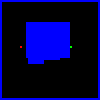

In [ ]:
from IPython.display import clear_output
done=True
video=cv.VideoWriter('snake.mp4',cv.VideoWriter_fourcc('m','p','4','v'),15,(100,100))
with tf.Session() as sess:
  saver.restore(sess,checkpoint_path)
  for gameLength in range(20):
    env()
    food()
    snake()
    for Length in range(200):
      clear_output(wait=True)
      if done:
        env()
        food()
        snake()
      q_values = online_q_values.eval(feed_dict={X_state: np.divide(cv.resize(img,(100,100)).reshape(-1,100,100,3),255)})
      action=np.argmax(q_values)
      state,_,next_state,reward,done=act(action)
      video.write(next_state)
      cv2_imshow(next_state)
video.release()